In [ ]:
# import libraries
import zipfile
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from google.colab import drive 

# mount my folder from google drive 
drive.mount('/dataset/') 

Mounted at /dataset/


## Data Ingestion

In [ ]:
# # unzip data to Google drive
# path_to_archive = '/dataset/MyDrive/datasets/petimages.zip'

# with zipfile.ZipFile(path_to_archive, 'r') as zip_ref:
#   zip_ref.extractall('/dataset/MyDrive/datasets/images/')

Now let's check how many files are contained in each folder.

In [ ]:
!ls /dataset/MyDrive/datasets/images/PetImages/Cat | wc -l
!ls /dataset/MyDrive/datasets/images/PetImages/Dog | wc -l

12405
12368


Both directories contain files. Dataset was succesfully uploaded. We observe, that both classes have almost the same number of images. There is no need to treat the class imbalance. So, now we are going to load images as a numpy array.

There was a problem with some of the images during the load. This led to errors, so a function was created that detected such files and deleted them. Such files turned out to be few in number. 

In [ ]:
# from PIL import Image

# directories = [source_folder_cats, source_folder_dogs]

# def remove_corrupted_images(directories):
#   """Removes empty files and files not of JPG format."""
#   for dir in directories:
#     print('Directory', dir)
#     files = os.listdir(dir)
#     size_old = len(files)
#     for f in files:      
#       filepath = os.path.join(dir, f)      
#       try:
#         img = Image.open(filepath)        
#         exif_data = img._getexif()
#         if os.stat(filepath).st_size == 0:
#           os.remove(filepath)
#       except AttributeError as err:
#         print("Error on image: ", img)
#         os.remove(filepath)
      
#     print(f'Totally was removed {size_old - len(os.listdir(dir))} files!')


# remove_corrupted_images(directories=directories)  

In [ ]:
# load the data
from tensorflow.keras.utils import image_dataset_from_directory

images_folder = '/dataset/MyDrive/datasets/images/PetImages/'
image_height = 256
image_width = 256
batch_size = 32

train = image_dataset_from_directory(images_folder, 
                                     seed=42, 
                                     batch_size=batch_size, 
                                     image_size=(image_height, image_width), 
                                     validation_split=0.2, 
                                     subset='training')

validation = image_dataset_from_directory(images_folder, 
                                     seed=42, 
                                     batch_size=batch_size, 
                                     image_size=(image_height, image_width), 
                                     validation_split=0.2, 
                                     subset='validation')
class_names = train.class_names

# to train the network with optimal architecture
full_dataset = image_dataset_from_directory(images_folder,            
                                     batch_size=batch_size, 
                                     image_size=(image_height, image_width))

Found 24773 files belonging to 2 classes.
Using 19819 files for training.
Found 24773 files belonging to 2 classes.
Using 4954 files for validation.
Found 24773 files belonging to 2 classes.


Let's plot the data!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


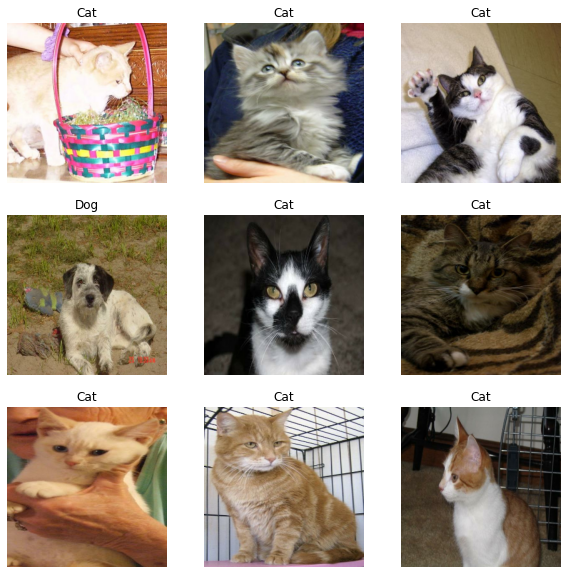

In [ ]:
# convert random image from the dataset
class_names = train.class_names

fig = plt.figure(figsize=(10, 10))
for images, labels in train.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# helper functions 
def plot_history(history):
  """Plots loss and accuracy of the train and test sets towards epoch."""
  epochs = np.arange(1, history.params['epochs'] + 1)

  f, ax = plt.subplots(1, 2, figsize=(15, 10))
  # loss
  ax[0].plot(epochs, history.history['loss'], label='train set')
  ax[0].plot(epochs, history.history['val_loss'], label='test set')
  ax[0].set_title('Loss')
  ax[0].legend()

  # accuracy
  ax[1].plot(epochs, history.history['accuracy'], label='train set')
  ax[1].plot(epochs, history.history['val_accuracy'], label='test set')
  ax[1].legend()
  ax[1].set_title('Accuracy')
  plt.show()

### Define the baseline

The objective of the modeling is to get accuracy more than 80% on the test set.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

early_stopping = ThresholdCallback(threshold=0.87)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

early_stopping = ThresholdCallback(threshold=0.87)

# model 
model = tf.keras.Sequential([
    layers.Rescaling(1./255), 
    layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3), 
        activation='relu', 
        input_shape=(image_height, image_width, 3)
    ), 
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    layers.Flatten(),
    layers.Dropout(0.5), 
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5), 
    layers.Dense(1, activation="sigmoid")
])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])

# history = model.fit(
#     train,
#     epochs=2, 
#     validation_data=validation,
# )

In [ ]:
model.save('/dataset/MyDrive/models/model_new.h5')

Train model on the full dataset.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(
    full_dataset,
    epochs=100, 
    callbacks=[early_stopping],
)

Epoch 1/100
775/775 [==============================] - 73s 93ms/step - loss: 0.7379 - accuracy: 0.6387
Epoch 2/100
775/775 [==============================] - 71s 91ms/step - loss: 0.6627 - accuracy: 0.7290
Epoch 3/100
775/775 [==============================] - 71s 91ms/step - loss: 0.6373 - accuracy: 0.7655
Epoch 4/100
775/775 [==============================] - 71s 91ms/step - loss: 0.6044 - accuracy: 0.7868
Epoch 5/100
775/775 [==============================] - 73s 93ms/step - loss: 0.5951 - accuracy: 0.8020
Epoch 6/100
775/775 [==============================] - 71s 91ms/step - loss: 0.5869 - accuracy: 0.8120
Epoch 7/100
775/775 [==============================] - 71s 91ms/step - loss: 0.5718 - accuracy: 0.8204
Epoch 8/100
775/775 [==============================] - 71s 91ms/step - loss: 0.5682 - accuracy: 0.8236
Epoch 9/100
775/775 [==============================] - 71s 91ms/step - loss: 0.5650 - accuracy: 0.8323
Epoch 10/100
775/775 [==============================] - 71s 91ms/step - l

In [ ]:
model.save('/dataset/MyDrive/models/model_full.h5')

This image most likely belongs to Dog with a 81.15 percent confidence.


(-0.5, 255.5, 255.5, -0.5)

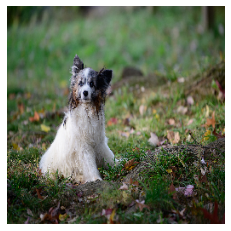

In [ ]:
new_model = tf.keras.models.load_model('/dataset/MyDrive/models/model_full.h5')
url = "/dataset/MyDrive/datasets/dog5.jpg" 

img = tf.keras.utils.load_img(url, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
input = tf.expand_dims(img_array, 0)

prediction_proba = new_model.predict(input)
predicted_label = tf.where(prediction_proba < 0.5, 0, 1)
label_proba = 100 * prediction_proba if prediction_proba > 0.5 else 100 * (1 - prediction_proba)

label = predicted_label.numpy()[0][0]

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[label], label_proba[0][0]))
plt.imshow(img_array / 255)
plt.axis('off')